In [2]:
from fastai.vision import *

In [7]:
path = Path('images/')

## Verify Images

In [3]:
for folder in ['Masks', 'No_Masks']:
    print(folder)
    verify_images(path/folder, delete=True, max_size=500)

Masks


No_Masks


## View Data

In [8]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2,
                                 ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [5]:
data.classes

['Masks', 'No_Masks']

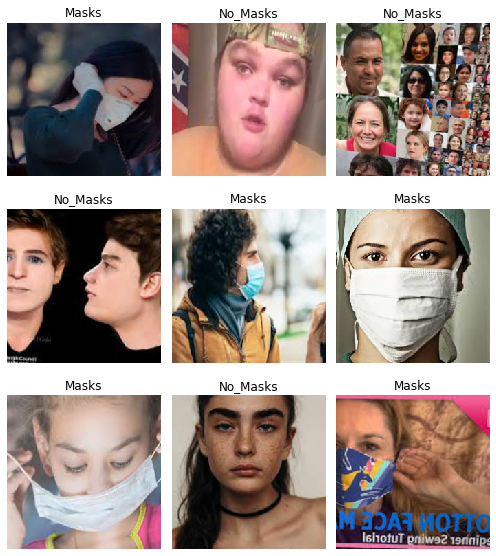

In [6]:
data.show_batch(rows=3, figsize=(7,8))

In [7]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Masks', 'No_Masks'], 2, 540, 134)

## Initial Training

In [3]:
from fastai.metrics import error_rate # 1 - accuracy

In [9]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [10]:
defaults.device = torch.device('cuda')
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.712863,0.558014,0.164179,00:52
1,0.419991,0.219732,0.059701,00:53
2,0.327240,0.199578,0.059701,00:53
3,0.258669,0.200557,0.059701,00:53


In [12]:
learn.save('face-mask-detection-stage-1')

In [13]:
learn.unfreeze()

In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


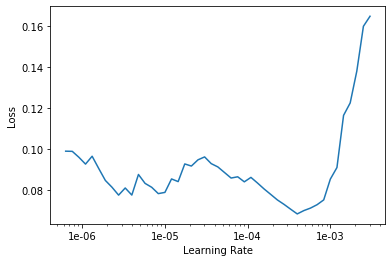

In [15]:
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(4, max_lr=slice(3e-5, 3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.100924,0.203773,0.059701,01:16
1,0.094471,0.203608,0.052239,01:16
2,0.069453,0.128843,0.044776,01:16
3,0.062733,0.099653,0.044776,01:16


In [17]:
learn.save('face-mask-detection-stage-1')

In [10]:
learn = learn.load('face-mask-detection-stage-1')

## Cleaning data

In [11]:
from fastai.widgets import *

In [12]:
ds, idxs = DatasetFormatter().from_toplosses(learn)

In [13]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [14]:
import pandas as pd

In [15]:
df = pd.read_csv(path/'cleaned.csv', header='infer')

In [16]:
df.head()

,name,label
0,Masks/mask_167.jpg,Masks
1,Masks/mask_73.jpg,Masks
2,Masks/mask_190.jpg,Masks
3,Masks/mask_535.jpg,Masks
4,Masks/mask_392.jpg,Masks


In [19]:
np.random.seed(42)
db = (ImageList.from_df(df, path)
                   .split_by_rand_pct(0.2)
                   .label_from_df()
                   .transform(get_transforms(), size=224)
                   .databunch(bs=8).normalize(imagenet_stats))

In [20]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Masks', 'No_Masks'], 2, 540, 134)

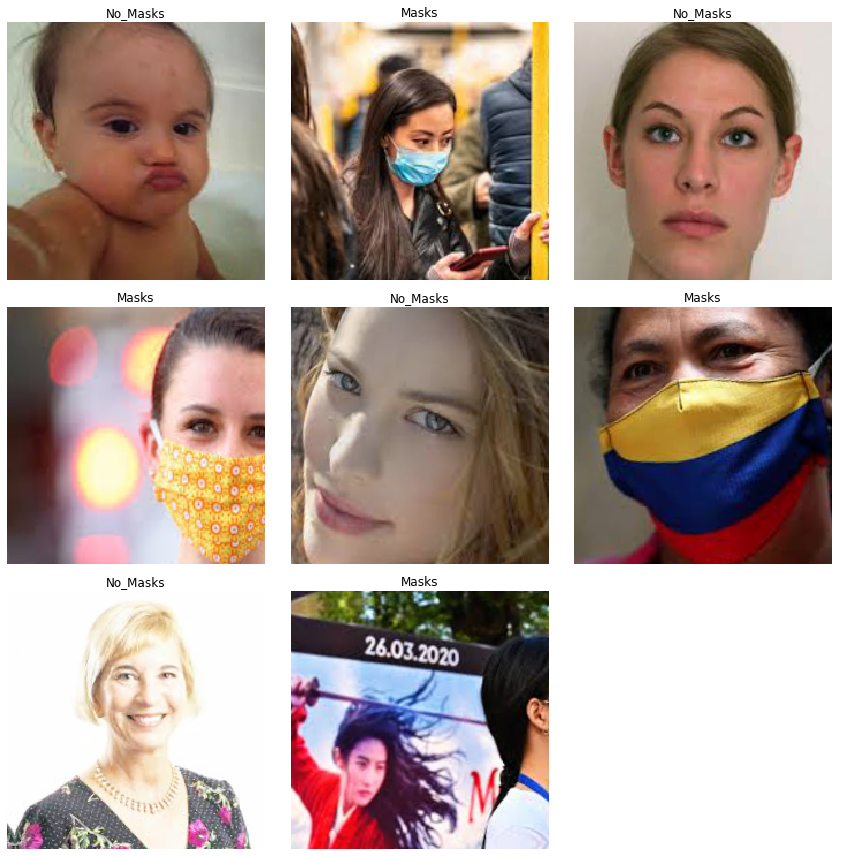

In [21]:
db.show_batch()

In [22]:
learn.data = db

In [23]:
learn.freeze()
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.212671,0.051842,0.028846,00:51
1,0.415193,0.198103,0.038462,00:52
2,0.281244,0.081882,0.019231,00:52
3,0.210689,0.087142,0.019231,00:52


In [24]:
learn.unfreeze()

In [25]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


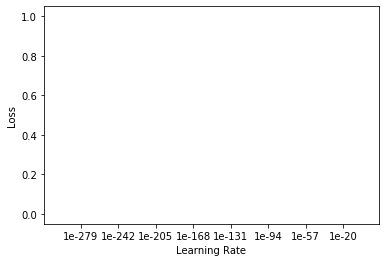

In [26]:
learn.recorder.plot()

In [27]:
learn.fit_one_cycle(4, max_lr=slice(3e-5, 3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.303444,0.098111,0.019231,01:12
1,0.261768,0.080530,0.057692,01:13
2,0.243616,0.117822,0.028846,01:12
3,0.216388,0.101974,0.009615,01:13


## Interpretation

In [28]:
interp = ClassificationInterpretation.from_learner(learn)

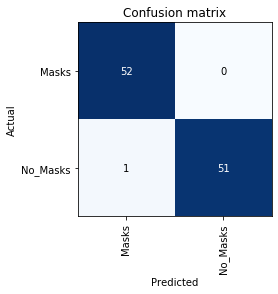

In [29]:
interp.plot_confusion_matrix()